# Alternative Analysis Using the Swing Weight Matrix

An IPython Notebook implementation of the Systems Engineering trade study method described at http://sebokwiki.org/wiki/Decision_Management.

## Table of Contents

0. [Import Modules](#Import)
1. [Declare Variables and Define Functions](#VarFunc)
2. [Input Files](#Input)
3. [Score Alternatives](#AltScoring)
4. [Calculate Swing Weights](#CalcSW)
5. [Evaluate Alternative Value](#AltValue)
6. [Visualize Output](#Viz)
7. [Create HTML Report](#Report)

In [42]:
%matplotlib inline

## Import Modules <a name="Import"></a>

In [43]:
from __future__ import division

import numpy as np
import scipy as sp
from scipy.special import expit

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid') # plot aesthetics
# plt.style.use('bmh') # plot aesthetics

import markdown
from jinja2 import Environment, FileSystemLoader

--------

## Variable and Function Declarations <a name="VarFunc"></a>

In [44]:
# distribution short names
sigString = 'sigmoid'
linString = 'linear'
powString = 'power'
triString = 'triangular'

# Value function range [0, vfRange]
vfRange = 100.0

# Weights for Importance and Swing for Swing Weight calculation
impWt = 0.65
swWt = 1.0 - impWt

# For large figures with subplots
numPlotCols = 3 # number of columns

# HTML output
htmlReport = True

#### Define the Allowable Value Functions 

In [45]:
# the linear, or scaled, function
def scale(x, xMin, xMax):
    """ Returns x between [0.0, 1.0] from original domain of [xMin, xMax]. """
    return (x - xMin) / (xMax - xMin)

# the triangular function
def triangular(x, l, c, r):
    """ Returns the [0,100] scaled triangular value function evaluated 
    at x for (l)eft, (c)enter, (r)ight triangular parameters."""
    return vfRange * max(min(((x - l)/(c - l)), ((r - x)/(r - c))), 0.0)

# the bell function
def bell(x, a, b, c):
    """ Returns the [0,100] scaled generalized bell curve 
    evaluated at x for (c)enter and shape parameters a and b."""
    return vfRange * 1.0 / (1.0 + pow(np.abs((x - c)/a), (2.0*b)))

# the sigmoid function
def sigmoid(x, a, c):
    """Returns the [0,100] scaled sigmoid function evaluated 
    at x for (a)lpha and (c)enter."""
    return vfRange * (1.0 / (1.0 + np.exp(-1.0 * a * (x - c))))


--------

## Read Input Files <a name="Input"></a>

### Objectives and Measures
Read directly into a `pandas` DataFrame

Define the set of value function families to use:

Family  |     Value Function Form
------- | -------------------------------------------
Linear  |  $$ f(x) = mx + b $$
Power   |  $$ f(x) = mx^a $$
Sigmoid |  $$ f(x) = \frac{a}{b + e^{-ax/2}} $$


In [46]:
objDF = pd.read_csv('./input/objectives.csv', index_col = ['Objective', 'Measure'])
# objDF   # Uncomment to view the DataFrame inline

#### Build the Value Functions for Each Objective and Measure
This section creates plots of the value functions defined for each measure.  The result is a series of figure with subplots of each value function.

----------
**Note:** *If you defined additional value functions above, you will need to add these to the below loop to make sure they are evaluated.*

---------

In [47]:
tmpDF = pd.DataFrame(columns=['Measure', 'Score', 'Value'])

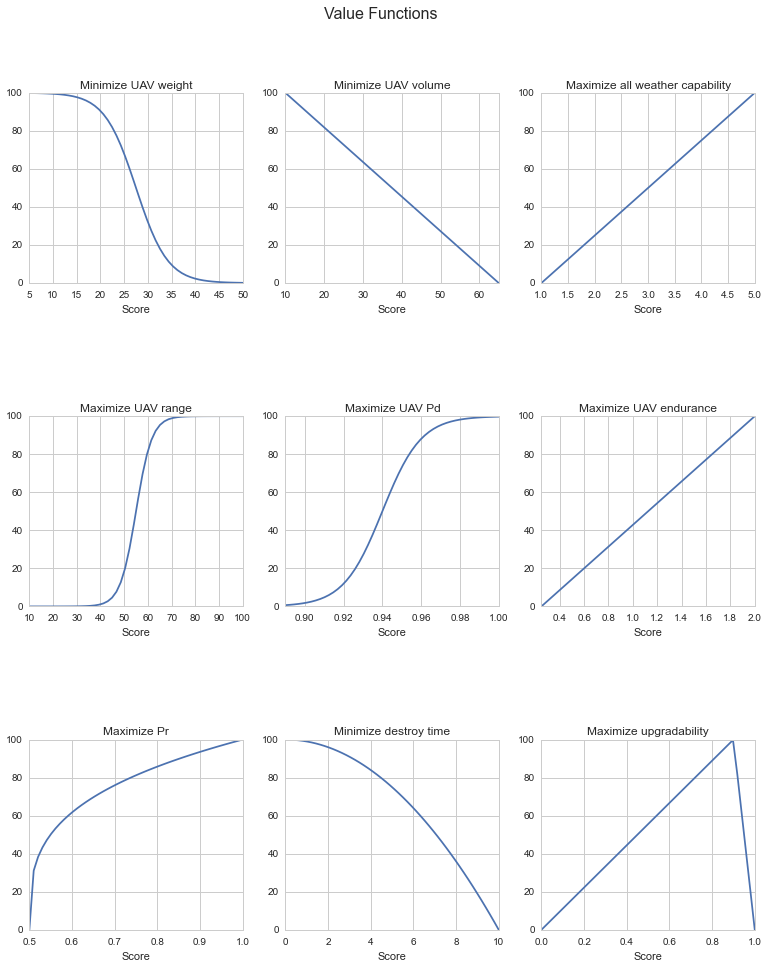

In [48]:
# Get the number of unique Measures to plot
numPlotRows = int(round(np.ceil(len(objDF.index.levels[1].unique()) / numPlotCols), 0))
fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize = (13, 15))

# Loop through the subplots and objDF indices
for ax, idx in zip(axs.flat, objDF.index):
    vals = objDF.loc[idx] # get the dataframe columns for this index 
    axMin = float(vals.Minimum)
    axMax = float(vals.Maximum)
    domain = np.linspace(axMin, axMax)
    
    # Build the corresponding value function
    if vals.Family == 'sigmoid':
        valFunc = [sigmoid(i, float(vals.Param1), vals.Param2) for i in domain]
        if float(vals.Slope) == -1.0:
            valFunc[:] = [vfRange - i for i in valFunc]
    elif vals.Family == 'linear':
        valFunc = [vfRange * scale(i, axMin, axMax) for i in domain]
        if float(vals.Slope) == -1.0:
            valFunc[:] = [vfRange - i for i in valFunc]
    elif vals.Family == 'power':
        valFunc = [vfRange * np.power(scale(i, axMin, axMax), vals.Param1) for i in domain]
        if float(vals.Slope) == -1.0:
            valFunc[:] = [max(valFunc) - i for i in valFunc]
    elif vals.Family == 'triangular':
        valFunc = [triangular(i, axMin, vals.Param1, axMax) for i in domain]
        if float(vals.Slope) == -1.0:
            valFunc[:] = [max(valFunc) - i for i in valFunc]
    else:
        valsFunc = [0]*len(domain)
        print 'This value function family is not yet implemented.'
    
    tmpDF.Measure = str(idx[1]) # Assign the Measure
    tmpDF.Score = domain
    tmpDF.Value = valFunc
    
    plotTitle = str(idx[1])
    
    tmpDF.plot(ax=ax, x = 'Score', y = 'Value', title = plotTitle, legend = False)
    plt.subplots_adjust(hspace = 0.7)
    
    
for ax in axs.flat[axs.size - 1:len(objDF.index) - 1:-1]:
    ax.set_visible(False)


plt.suptitle('Value Functions', fontsize = 16)
plt.savefig('./html_report/images/value-functions.png', bbox_inches='tight')
plt.savefig('./html_report/images/value-functions.pdf', bbox_inches='tight')

plt.show()

### Alternatives
Read directly into a `pandas` DataFrame

In [49]:
altDF = pd.read_csv('./input/alternatives.csv', index_col=['Objective', 'Measure', 'Alternative'])


# Create and intialize a columns for Consequence
altDF['Consequence'] = np.NaN
# altDF   #  Uncomment to view inline


--------

## Score each Alternative against each Objective and Measure <a name="AltScoring"></a>

In [50]:
for item, val in altDF.iterrows():
    idxString = list(item) # convert this alternative's index to a list
    print '\n\nidxString is: ', idxString
    print 'val is: \n -----\n', val, '\n-----'
    objIdx = idxString[0:2] # drop the 'Alternative' from the index used for the objective DataFrame
    print 'objective index is: \n', objIdx
    obj = objDF.ix[objIdx[0],objIdx[1],] # get the corresponding objective for this index
    print 'objDF row is: \n', obj
    
    score = np.NaN
    funcFamily = str(obj['Family']) # get the corresponding value function family
    paramX = altDF.ix[idxString[0], idxString[1], idxString[2]]['Score'] # the measured value for this alternative
    paramSlope = objDF.ix[objIdx[0],objIdx[1]]['Slope'] # the slope
    paramXMin = objDF.ix[objIdx[0],objIdx[1]]['Minimum'] # minimum acceptable
    paramXMax = objDF.ix[objIdx[0],objIdx[1]]['Maximum'] # maximum desirable
    paramX1 = objDF.ix[objIdx[0],objIdx[1]]['Param1'] # 1st function parameter
    paramX2 = objDF.ix[objIdx[0],objIdx[1]]['Param2'] # 2nd function parameter
    paramX3 = objDF.ix[objIdx[0],objIdx[1]]['Param3'] # 3rd function parameter

    if funcFamily == sigString:
        print str(idxString[0:2]) + ' is ' + sigString
        score = sigmoid(paramX, paramX1, paramX2)
        if float(paramSlope) == -1.0:
            score = vfRange - score
    elif funcFamily == linString:
        print str(idxString[0:2]) + ' is ' + linString
        score = vfRange * scale(paramX, paramXMin, paramXMax)
        if float(paramSlope) == -1.0:
            score = vfRange - score
    elif funcFamily == powString:
        print str(idxString[0:2]) + ' is ' + powString
        score = np.power(scale(paramX, paramXMin, paramXMax), paramX1) #pow_func(paramX, 2.0, paramXMin, paramXMax)
        if float(paramSlope) == -1.0:
            score = vfRange - score
    elif funcFamily == triString:
        print str(idxString[0:2]) + ' is ' + triString
        score = triangular(paramX, paramXMin, paramX1, paramXMax)
        if float(paramSlope) == -1.0:
            score = vfRange - score
    else:
        print 'The "',funcFamily, '" value function family is not yet implemented.'
        
    if score > 100.0:
        score = 100.0
    elif score < 0.0:
        score = 0.0

    print 'Value against this measure is ', score
    altDF.loc[(idxString[0], idxString[1], idxString[2]),'Consequence'] = np.round(float(score), 3)
                  




idxString is:  ['Relocate UAV', 'Minimize UAV weight', 'Cardinal']
val is: 
 -----
Score            5
Units          lbs
Consequence    NaN
Name: (Relocate UAV, Minimize UAV weight, Cardinal), dtype: object 
-----
objective index is: 
['Relocate UAV', 'Minimize UAV weight']
objDF row is: 
Importance         35
Minimum             5
Maximum            50
Ideal               5
Units             lbs
Family        sigmoid
Slope              -1
Param1            0.3
Param2           27.5
Param3            NaN
Name: (Relocate UAV, Minimize UAV weight), dtype: object
['Relocate UAV', 'Minimize UAV weight'] is sigmoid
Value against this measure is  99.8830489735


idxString is:  ['Relocate UAV', 'Minimize UAV volume', 'Cardinal']
val is: 
 -----
Score           12
Units          ft3
Consequence    NaN
Name: (Relocate UAV, Minimize UAV volume, Cardinal), dtype: object 
-----
objective index is: 
['Relocate UAV', 'Minimize UAV volume']
objDF row is: 
Importance        45
Minimum           10
M

In [51]:
print altDF['Score'].dropna('index')   # Uncomment to view the DataFrame inline

Objective     Measure                          Alternative
Relocate UAV  Minimize UAV weight              Cardinal         5.00
              Minimize UAV volume              Cardinal        12.00
Employ UAV    Maximize all weather capability  Cardinal         3.00
              Maximize UAV range               Cardinal        10.00
              Maximize UAV Pd                  Cardinal         0.92
              Maximize UAV endurance           Cardinal         0.50
Relocate UAV  Minimize UAV weight              Buzzard         10.00
              Minimize UAV volume              Buzzard         15.00
Employ UAV    Maximize all weather capability  Buzzard          1.00
              Maximize UAV range               Buzzard         10.00
              Maximize UAV Pd                  Buzzard          0.90
              Maximize UAV endurance           Buzzard          1.00
Relocate UAV  Minimize UAV weight              Crow            10.00
              Minimize UAV volume           

-----------

## Calculate the Swing Weight for each Objective and Measure <a name="CalcSW"></a>

In [52]:
objDF.loc[:,'Swing'] = np.NaN

In [53]:
for idx, val in objDF.iterrows():
    try:
        objMin = min(altDF.loc[(idx[0], idx[1]),'Consequence'])
        objMax = max(altDF.loc[(idx[0], idx[1]),'Consequence'])
    except:
        print "\nNo Score found for ", idx
        objMin = np.NaN
        objMax = np.NaN
        
    swing = objMax - objMin
    objDF.loc[(idx[0], idx[1]),'Swing'] = swing
    print idx, ' min: ', objMin, '  max: ', objMax, '  swing: ', swing

('Relocate UAV', 'Minimize UAV weight')  min:  2.298   max:  99.883   swing:  97.585
('Relocate UAV', 'Minimize UAV volume')  min:  27.273   max:  96.364   swing:  69.091
('Employ UAV', 'Maximize all weather capability')  min:  0.0   max:  100.0   swing:  100.0
('Employ UAV', 'Maximize UAV range')  min:  0.0   max:  100.0   swing:  100.0
('Employ UAV', 'Maximize UAV Pd')  min:  1.799   max:  50.0   swing:  48.201
('Employ UAV', 'Maximize UAV endurance')  min:  14.286   max:  100.0   swing:  85.714

No Score found for  ('Recover UAV', 'Maximize Pr')
('Recover UAV', 'Maximize Pr')  min:  nan   max:  nan   swing:  nan

No Score found for  ('Recover UAV', 'Minimize destroy time')
('Recover UAV', 'Minimize destroy time')  min:  nan   max:  nan   swing:  nan

No Score found for  ('Growth Potential', 'Maximize upgradability')
('Growth Potential', 'Maximize upgradability')  min:  nan   max:  nan   swing:  nan


In [54]:
# objDF

In [55]:
objResults = objDF.copy()
objResults.reset_index(inplace=True)

objResults


,Objective,Measure,Importance,Minimum,Maximum,Ideal,Units,Family,Slope,Param1,Param2,Param3,Swing
0,Relocate UAV,Minimize UAV weight,35,5.00,50,5.0,lbs,sigmoid,-1,0.3,27.50,NaN,97.585
1,Relocate UAV,Minimize UAV volume,45,10.00,65,10.0,ft3,linear,-1,NaN,NaN,NaN,69.091
2,Employ UAV,Maximize all weather capability,70,1.00,5,5.0,index,linear,1,NaN,NaN,NaN,100.000
3,Employ UAV,Maximize UAV range,80,10.00,100,100.0,km,sigmoid,1,0.3,55.00,NaN,100.000
4,Employ UAV,Maximize UAV Pd,90,0.89,1,1.0,probability,sigmoid,1,100.0,0.94,NaN,48.201
5,Employ UAV,Maximize UAV endurance,100,0.25,2,2.0,hours,linear,1,NaN,NaN,NaN,85.714
6,Recover UAV,Maximize Pr,65,0.50,1,1.0,probability,power,1,0.3,NaN,NaN,NaN
7,Recover UAV,Minimize destroy time,50,0.00,10,0.0,seconds,power,-1,2.0,NaN,NaN,NaN
8,Growth Potential,Maximize upgradability,85,0.00,1,0.9,index,triangular,1,0.9,NaN,NaN,NaN


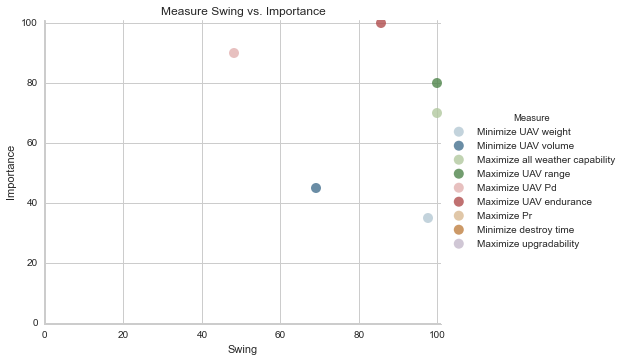

In [56]:
# sns.set(style='whitegrid')
sns.lmplot(x="Swing", y="Importance", data=objResults, fit_reg=False, hue = "Measure", aspect=1.3, 
           scatter_kws={"s": 100}, palette=sns.color_palette("Paired", n_colors=16, desat=.5))#palette='Accent')
plt.xlim(-0.1,101)
plt.ylim(-0.1,101)
plt.title("Measure Swing vs. Importance")
plt.savefig('./html_report/images/swing-importance.png', bbox_inches='tight')
plt.savefig('./html_report/images/swing-importance.pdf', bbox_inches='tight')

### Calculate the Unnormalized Weight

In [57]:
objDF.loc[:,'Weight'] = impWt * objDF.Importance + swWt * objDF.Swing

### Calculate the Normalized Weight

In [58]:
objDF.loc[:,'NormdWt'] = objDF.loc[:,'Weight'] / objDF.loc[:,'Weight'].sum()

In [59]:
# objDF   # Uncomment to view the DataFrame inline

-------------

## Evaluating the Alternative's Value <a name="AltValue"></a>

### Calculate Total Value for Each Alternative

$$
V(x) = \sum_{i = 1}^{n}w_{i} v_{i}(x_{i})
$$
where $V(x)$ is the total value, $i$ is the index of the objective/measure, $w_i$ is the normalized weight for objective/measure $i$, $x_i$ is the alternative's score for objective measure $i$, and $v_i(x_i)$ is the corresponding value of $x_i$.

In [60]:
for idx, vals in altDF.iterrows():
    altDF.loc[:,'WtdConsequence'] = objDF.loc[(idx[0],idx[1]),'NormdWt'] * altDF.Consequence


In [61]:
# altDF    # Uncomment to view the DataFrame inline
print altDF['WtdConsequence'].dropna('index')

Objective     Measure                          Alternative
Relocate UAV  Minimize UAV weight              Cardinal       21.170750
              Minimize UAV volume              Cardinal       20.424878
Employ UAV    Maximize all weather capability  Cardinal       10.597774
              Maximize UAV range               Cardinal        0.000000
              Maximize UAV Pd                  Cardinal        2.526509
              Maximize UAV endurance           Cardinal        3.027996
Relocate UAV  Minimize UAV weight              Buzzard        21.084908
              Minimize UAV volume              Buzzard        19.268661
Employ UAV    Maximize all weather capability  Buzzard         0.000000
              Maximize UAV range               Buzzard         0.000000
              Maximize UAV Pd                  Buzzard         0.381308
              Maximize UAV endurance           Buzzard         9.083776
Relocate UAV  Minimize UAV weight              Crow           21.084908
     

------------

## Visualizing Output <a name="Viz"></a>

#### Heatmap (Consequences Scorecard)

Display the relative performance of each Alternative against each Measure.

In [62]:
heatDF = altDF.drop(['Score', 'Units', 'WtdConsequence'], axis = 1)
heatDF.reset_index(inplace=True)

In [63]:
summaryDF = altDF.drop(['Score', 'Consequence'], axis=1).groupby(level = 'Alternative').agg(sum)
summaryDF.columns = ['Value']
# summaryDF   # Uncomment to view the DataFrame inline

In [64]:
tmpDF = altDF.drop(['Units', 'Consequence'], axis = 1)
# tmpDF   # Uncomment to view the DataFrame inline

In [65]:
for idx, cols in tmpDF.iterrows():
    val = summaryDF.loc[(idx[2]), 'Value']
    tmpDF.loc[idx,'Value'] = val


In [66]:
heat_rect = heatDF.pivot('Alternative', 'Measure', 'Consequence')
# heat_rect.dropna("columns")   # Uncomment to view the DataFrame inline

In [67]:
heat_rect

Measure,Maximize UAV Pd,Maximize UAV endurance,Maximize UAV range,Maximize all weather capability,Minimize UAV volume,Minimize UAV weight
Alternative,,,,,,
Buzzard,1.799,42.857,0.000,0,90.909,99.478
Cardinal,11.920,14.286,0.000,50,96.364,99.883
Crow,11.920,42.857,98.901,50,81.818,99.478
Dove,50.000,100.000,100.000,100,27.273,2.298
Pigeon,11.920,71.429,99.945,50,63.636,97.702
Robin,1.799,100.000,99.997,0,45.455,32.082


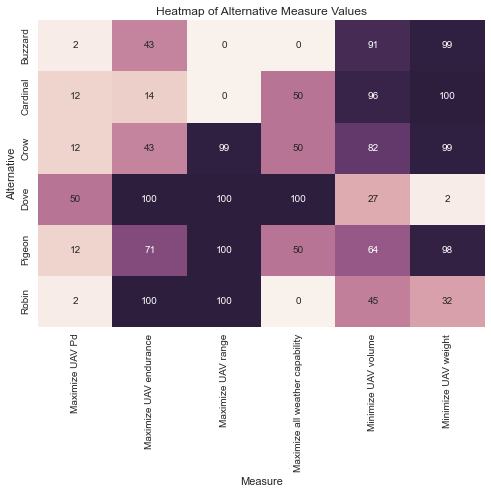

In [68]:
sns.heatmap(np.round(heat_rect.dropna('columns'), 0), annot=True, fmt='g', cbar=False)
plt.title("Heatmap of Alternative Measure Values")
plt.savefig('./html_report/images/value-scorecard.png', bbox_inches='tight')
plt.savefig('./html_report/images/value-scorecard.pdf', bbox_inches='tight')

#### Trellis Plot of Alternative Value vs Measure Score

Allows a quick comparison of the total value and original score of Alternatives against all Measures.

In [69]:
summaryDF.reset_index(inplace=True)

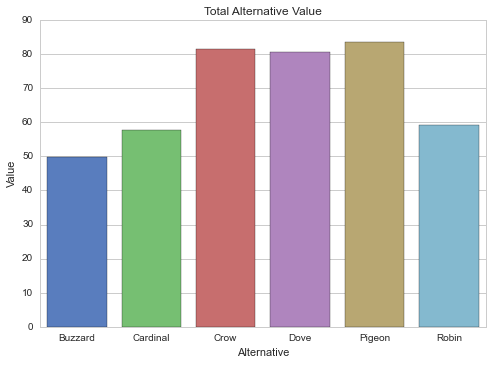

In [70]:
sns.barplot('Alternative', 'Value', data=summaryDF, palette='muted')
plt.ylabel("Value")
plt.title('Total Alternative Value')
plt.savefig('./html_report/images/value-barplot.png', bbox_inches='tight')
plt.savefig('./html_report/images/value-barplot.pdf', bbox_inches='tight')

In [71]:
summaryDF

,Alternative,Value
0,Buzzard,49.818653
1,Cardinal,57.747908
2,Crow,81.597351
3,Dove,80.452155
4,Pigeon,83.644417
5,Robin,59.206161


In [72]:
tmpDF.reset_index(inplace=True)

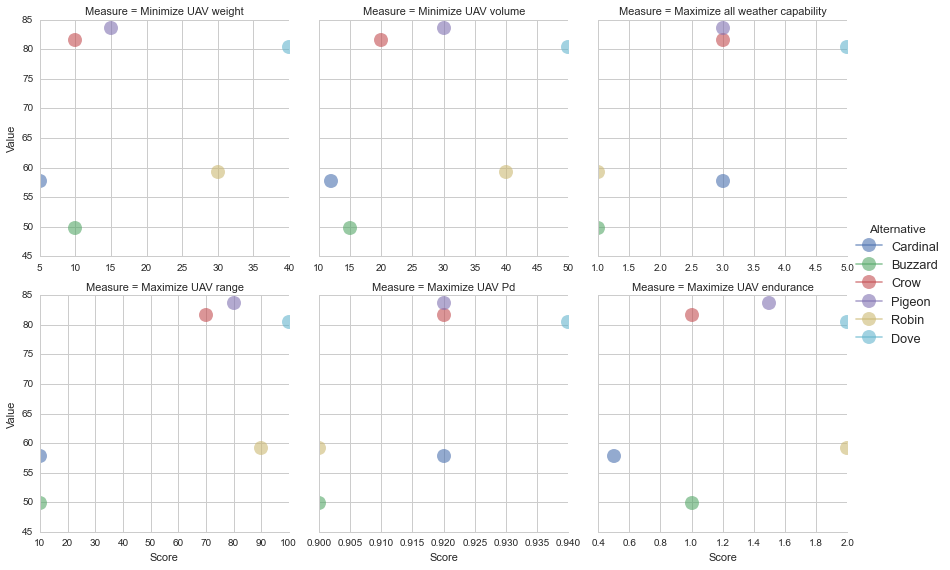

In [73]:
grid = sns.FacetGrid(tmpDF, col="Measure", hue="Alternative", col_wrap=3, size=4, legend_out = True, sharex=False, 
                    sharey=True)
grid.map(plt.plot, "Score", "Value", marker="o", ms=14, alpha=0.6)
grid.fig.tight_layout(w_pad=1)
sns.set_context("paper", font_scale=1.6)
grid.add_legend()
grid.savefig('./html_report/images/measure-trellis.png', bbox_inches='tight')
grid.savefig('./html_report/images/measure-trellis.pdf', bbox_inches='tight')

Format the DataFrame to produce the parallel coordinates plot.


In [74]:
fooDF = heat_rect.copy()

In [75]:
# fooDF

In [76]:
# normalize the measure values for the parallel coordinates plot
for col in fooDF.columns:
    fooDF[col] = (fooDF[col] - np.min(fooDF[col])) / (np.max(fooDF[col]) - np.min(fooDF[col]))

fooDF

Measure,Maximize UAV Pd,Maximize UAV endurance,Maximize UAV range,Maximize all weather capability,Minimize UAV volume,Minimize UAV weight
Alternative,,,,,,
Buzzard,0.000000,0.333329,0.00000,0.0,0.921046,0.995850
Cardinal,0.209975,0.000000,0.00000,0.5,1.000000,1.000000
Crow,0.209975,0.333329,0.98901,0.5,0.789466,0.995850
Dove,1.000000,1.000000,1.00000,1.0,0.000000,0.000000
Pigeon,0.209975,0.666671,0.99945,0.5,0.526306,0.977650
Robin,0.000000,1.000000,0.99997,0.0,0.263160,0.305211


In [77]:
fooDF = fooDF.reset_index(level=0,drop = False) # reset the index, but keep 'Alternative' as a column

In [78]:
fooDF.index.name = None

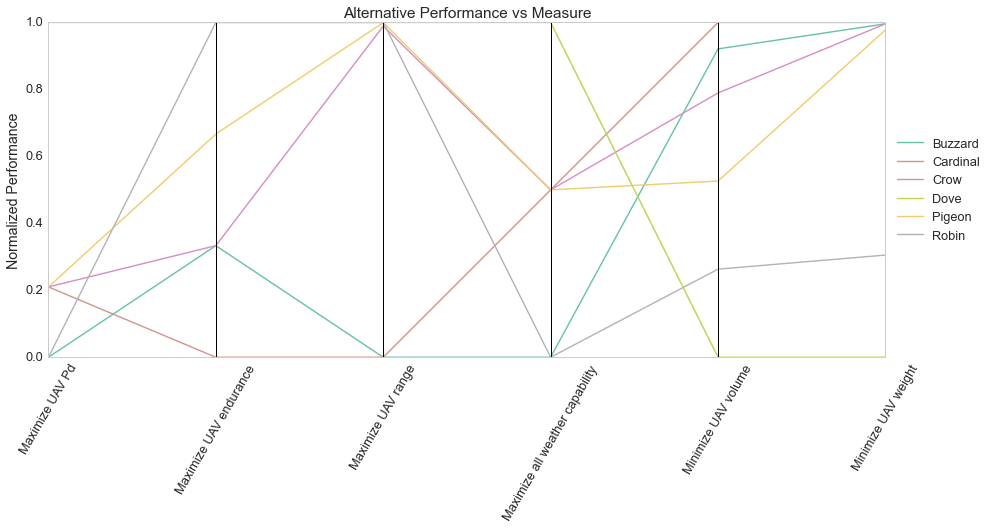

In [79]:
plt.figure(figsize = (15,6))
pd.tools.plotting.parallel_coordinates(fooDF, 'Alternative', colormap = 'Set2')
plt.xticks(rotation=60)
plt.ylabel("Normalized Performance")
plt.title('Alternative Performance vs Measure')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('./html_report/images/parallel-coordinates.png', bbox_inches='tight')
plt.savefig('./html_report/images/parallel-coordinates.pdf', bbox_inches='tight')

-----------------

## Create HTML Report <a name="Report"></a>

You can manipulate the string variable below for your needs.  These are used in the default template.

In [80]:
if htmlReport:
    # Adjust these strings to your needs:
    pageTitle = "alt-swing"
    reportTitle = "Default alt-swing Report"
    author = "Author Name"
    frontMatter = "This is the default alt-swing report.  You can customize it for your needs."
    content = "Lorem ipsum dolor sit amet, consectetur adipiscing elit."
    trellis_text = "Nunc vel gravida dui, ac aliquam augue. Vivamus eu ultrices mauris, sit amet dictum diam."
    barplot_text = "Vivamus eu ultrices dui, ac aliquam augue."
    
    # Convert tables
    summaryDF = altDF.drop(['Score', 'Consequence'], axis=1).groupby(level = 'Alternative').agg(sum)
    summaryDF.columns = ['Value']
    
    altTable = pd.read_csv('./input/alternatives.csv', index_col=['Objective', 'Measure', 'Alternative', 'Units'])
    altTable = altTable.unstack(['Objective', 'Measure', 'Units'])
    
    blufHTML = summaryDF.to_html()\
                .replace('<table border="1" class="dataframe">','<table border="0" style="font-size:80%"">')
    
    altHTML = altTable.to_html()\
                .replace('<table border="1" class="dataframe">','<table border="0" style="font-size:80%">')
    
    objHTML = objDF.drop(['Family', 'Slope', 'Param1', 'Param2', 'Param3', 'Weight'], axis=1).to_html()\
                .replace('<table border="1" class="dataframe">','<table border="0" style="font-size:80%">')
    
    # Read and convert markdown sections
    with open('./templates/content/intro-section.md', 'r') as f:
        introText = markdown.markdown(f.read())
    
    with open('./templates/content/bluf-section.md', 'r') as f:
        blufText = markdown.markdown(f.read())
        
    with open('./templates/content/obj_meas-section.md', 'r') as f:
        obj_measText = markdown.markdown(f.read())

    with open('./templates/content/alternative-section.md', 'r') as f:
        altText = markdown.markdown(f.read())
    
    env = Environment(loader=FileSystemLoader('./templates/'))
    template = env.get_template('template.html')
    
    # 
    output_from_parsed_template = template.render(
        title = reportTitle, page_title = pageTitle, author = author,
        bluf_content = blufText, bluf_table = blufHTML, 
        intro_content = introText, 
        obj_content = obj_measText, obj_meas_table = objHTML,
        alt_content = altText, alt_table = altHTML, 
        trellis_text = trellis_text, barplot_text = barplot_text
        )

    output_from_parsed_template = output_from_parsed_template.encode("utf-8")
    
    # Write the HTML report
    with open("./html_report/alt-swing_report.html", "w") as fh:
        fh.write(output_from_parsed_template)
    


You can now open the HTML document at `./html_report/alt-swing_report.html`.  The default template uses the [Skeleton](http://www.getskeleton.com) CSS framework.

-----------